In [15]:
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

import random
random.seed(10)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import uniform
import scipy.stats as st


import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import GammaRegressor
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn import metrics


# Track 1 - Spend Analysis

In [169]:
df = pd.read_excel('master_file_markets_data_v2.0.xlsx')

#df = df.drop('Unnamed: 0', axis = 1)
df.head()

,id,POS,Region,Origin,Market,Airline,Spend,Segments,Discount,Savings,Airport_1,Airport_2,Market_type,Market_Competition,predicted_savings
0,1,US,NAMR,JFK,GRU-JFK,American Air,193268,43,0.0,0,Brazil,United States,International,Competitive,0
1,2,US,NAMR,JFK,JFK-JNB,South Africa,134661,23,0.0,0,United States,South Africa,International,Uncompetitive,0
2,3,BE,EURO,BRU,BRU-JFK,Delta Air Lines,123421,48,0.0,0,Belgium,United States,International,Highly Competitive,0
3,4,US,NAMR,JFK,GRU-JFK,Delta Air Lines,78410,16,0.0,0,Brazil,United States,International,Competitive,0
4,5,BE,EURO,BLR,BLR-GRU,Emirates,47072,9,0.0,0,India,Brazil,International,Uncompetitive,0


# Savings Predictions for Sub-optimal markets

In [212]:
dffull = pd.read_excel('master_file_markets_data_v2.0.xlsx')
dfcopy = dffull.copy()

#dropping columns that are not required, dropping markets with zero savings
#df = dffull.drop('id', axis = 1)
df = dffull.loc[dffull.Savings != 0] #training and testing set

# Definitions of training and testing data
# Validation data will only be suboptimal markets where, Savings = 0

df = df[['Segments','Spend','Market_type','Market_Competition','Savings']]


# Feature Encoding for machine learnign training

# Label Encoding
le = LabelEncoder()
df.Market_type = le.fit_transform(df.Market_type)
df.Market_Competition = le.fit_transform(df.Market_Competition)

'''
# One Hot Encoding

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    handle_unknown='error' # Whether to raise an error 
)        

ohe = OneHotEncoder() 


#OHE Encoding for column: POS
transformed = ohe.fit_transform(df[['POS']])
transformed = pd.DataFrame(data = transformed.toarray(), columns = ohe.get_feature_names())
df = df.drop('POS', axis = 1)
df = pd.concat([df, transformed], axis=1, join="inner")


#OHE Encoding for column: Region
transformed = ohe.fit_transform(df[['Region']])
transformed = pd.DataFrame(data = transformed.toarray(), columns = ohe.get_feature_names())
df = df.drop('Region', axis = 1)
df = pd.concat([df, transformed], axis=1, join="inner")

'''

# Extreme value removel
df = df.loc[df.Savings <= 5000]

# Standardisation and Normalisation for machine learnign training


# target 
#y = pd.DataFrame(data = dftest['y'])
y = df['Savings']

#features
x = df.drop('Savings', axis = 1)

# train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, shuffle = True)


# MODELLING

# Model Definitions List

model_list = [RandomForestRegressor(n_estimators = 300, bootstrap = False, max_depth = 10, max_features = 4)]

#result storing lists; later to be used to generate dfresults dataframe
model_def = []
score_accuracy_list = []
score_explainedvariance_list = []
score_meanabsoluteerror_list = []

    
# storing model functions; later to be used in dfresults dataframe
for model in model_list:
    text = str(model)
    #model_type = text.split(".")[-1].split("'")[0]
    model_type = text
    model_def.append(model_type)

    
# model fitting and testing loop

for model in model_list: 
    
    #fitting
    fitted_model = model.fit(xtrain,ytrain)
    
    print('Model training completed completed for: ', model)
    
    ypred = fitted_model.predict(xtest)
    
    # scoring
    
    
    score_accuracy_list.append(fitted_model.score(xtest,ytest)) #calculate and append Accuracy
    score_explainedvariance_list.append(explained_variance_score(ytest,ypred)) #calculate and append R2 score
    score_meanabsoluteerror_list.append(mean_absolute_error(ytest,ypred)) #calculate and append R2 score


# Result storing - temporary
    
# result dataframe genertor, dfresults will be over written for new training runs
dfresults = pd.DataFrame(data = {'model':model_def, 'score_accuracy':score_accuracy_list, 
                                 'score_explained_variance':score_explainedvariance_list, 
                                 'score_mean_absolute_error':score_meanabsoluteerror_list})


# Result storing - permanent
 
#create a master file to store all results after training runs
#this below code needs to be seperated from training run cell
#re-executing the creation of dfresults_master will overwrite the dataframe

#load external csv file for result storage
dfresults_master = pd.read_csv('dfresults_master.csv')

#pre_processing dfresults_master to remove unnamed columns
Unname_columns_list = []
for column in dfresults_master.columns.to_list():
    if 'Unnamed' in column:
        Unname_columns_list.append(column)
dfresults_master = dfresults_master.drop(Unname_columns_list, axis = 1)

#append dataframe with results
dfresults_master = dfresults_master.append(dfresults) # stroing model testing scores into master dataframe
dfresults_master = dfresults_master[1:] #removing dummy observation 

#Removing any unknown columns that may have been appended
Unname_columns_list = []
for column in dfresults_master.columns.to_list():
    if 'Unnamed' in column:
        Unname_columns_list.append(column)

dfresults_master = dfresults_master.drop(Unname_columns_list, axis = 1)

#replace orgininally loaded file with new dataframe export
dfresults_master.to_csv('dfresults_master.csv')

dfresults

#results need to be stored in dfresults_master for premanent record of all models trained

Model training completed completed for:  RandomForestRegressor(bootstrap=False, max_depth=10, max_features=4,
                      n_estimators=300)


,model,score_accuracy,score_explained_variance,score_mean_absolute_error
0,"RandomForestRegressor(bootstrap=False, max_depth=10, max_features=4,\n n_estimators=300)",0.57,0.57,85.91


In [76]:
xtrain.head().columns.to_list()

['Segments', 'Spend', 'Market_type', 'Market_Competition']

In [74]:
fitted_model.coef_

array([-1.95452335,  0.09651443, 90.82897186, -6.29334807])

In [240]:
# SAVING AND LOADING THE fitted_model

model_file_name = 'model_RandomForestRegressor_v2_11-27-22.sav'
pickle.dump(fitted_model, open(model_file_name, 'wb'))

# load the model from disk
#fitted_model = pickle.load(open(filename, 'rb'))

In [202]:
ytest = pd.DataFrame(data = ytest)
ytest.describe()

,Savings
count,4427.000
mean,149.910
std,396.965
min,1.000
25%,13.000
50%,33.000
75%,96.000
max,4944.000


In [213]:
ypred = pd.DataFrame(data = ypred, columns = ['ypred'])
ypred.describe()

,ypred
count,4427.000
mean,155.838
std,402.266
min,3.429
25%,17.503
50%,36.896
75%,110.181
max,4764.000


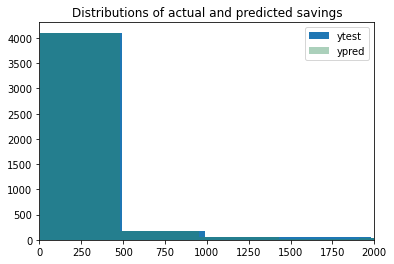

In [221]:
plt.hist(ytest, label = 'ytest')
plt.hist(ypred, label = 'ypred', color = 'seagreen', alpha = 0.4)
plt.xlim(0,2000)
plt.legend()
plt.title('Distributions of actual and predicted savings')
plt.show()

# Model Optimization

In [62]:
%%time
# Creating a dictionary to define hyperparameter search range

model = RandomForestRegressor()

# 'criterion' : ["squared_error","absolute_error","poisson"]

hyper_parameter_range = {'n_estimators' : [300],
                 'max_depth' : [10,15],
                 'max_features' : [4,2],
                 'bootstrap' : ['False']
                        }

search_optimizer = GridSearchCV(model, hyper_parameter_range)

search_optimizer.fit(x,y)

CPU times: user 50.6 s, sys: 796 ms, total: 51.4 s
Wall time: 51.6 s


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': ['False'], 'max_depth': [10, 15],
                         'max_features': [4, 2], 'n_estimators': [300]})

In [64]:
search_optimizer.best_params_

{'bootstrap': 'False', 'max_depth': 10, 'max_features': 4, 'n_estimators': 300}

# Results Master Analysis for Model Selection

In [55]:
# full data export within predictions for sub-optimal markets included
dffull.to_excel('master_file_predictions_v0.xlsx')

In [10]:
dfresults_master = pd.read_csv('dfresults_master.csv')
#Removing any unknown columns that may have been appended
Unname_columns_list = []
for column in dfresults_master.columns.to_list():
    if 'Unnamed' in column:
        Unname_columns_list.append(column)

dfresults_master = dfresults_master.drop(Unname_columns_list, axis = 1)

print(dfresults_master.head())

print(dfresults_master.describe())

                                 model  score_accuracy  \
0                  AdaBoostRegressor()           0.541   
1  AdaBoostRegressor(n_estimators=100)           0.538   
2  AdaBoostRegressor(n_estimators=150)           0.540   
3  AdaBoostRegressor(n_estimators=200)           0.513   
4  AdaBoostRegressor(n_estimators=250)           0.532   

   score_explained_variance  score_mean_absolute_error  
0                     0.554                    308.049  
1                     0.550                    306.834  
2                     0.551                    306.767  
3                     0.529                    313.742  
4                     0.541                    302.223  
       score_accuracy  score_explained_variance  score_mean_absolute_error
count          40.000                    40.000                     40.000
mean            0.591                     0.593                    205.493
std             0.063                     0.061                    104.674
min      

In [11]:
dfresults_master.groupby(["model"]).mean().sort_values(by = ['score_mean_absolute_error'])

,score_accuracy,score_explained_variance,score_mean_absolute_error
model,,,
"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4)",0.663,0.663,78.461
LinearRegression(),0.656,0.656,83.889
RandomForestRegressor(),0.615,0.615,167.441
RandomForestRegressor(n_estimators=200),0.594,0.594,200.642
RandomForestRegressor(n_estimators=300),0.593,0.593,201.149
RandomForestRegressor(n_estimators=250),0.593,0.593,201.286
RandomForestRegressor(n_estimators=150),0.591,0.592,201.831
RandomForestRegressor(n_estimators=50),0.592,0.593,201.998
AdaBoostRegressor(n_estimators=250),0.532,0.541,302.223


# Producing Savings Estimates for Sub-optimal Markets

In [ ]:


counter = 0

for id in dffull.index:
    
    
    if dffull['Savings'][id] == 0:
        
        xtest = dffull[['Segments','Spend','Market_type','Market_Competition']][id:id+1]

        # Feature Encoding for machine learnign training

        # Label Encoding
        le = LabelEncoder()
        xtest.Market_type = le.fit_transform(xtest.Market_type)
        xtest.Market_Competition = le.fit_transform(xtest.Market_Competition)
        
        ypred = int(fitted_model.predict(xtest))
        
        dffull['predicted_savings'][id:id+1] = ypred  
        
        print(dffull[id:id+1])

In [ ]:
df.head()

# Analysis of Predicted Savings (based on master_predictions_vx)

In [222]:
df = pd.read_excel('master_file_predictions_v0.xlsx')

In [7]:
df.head()

,Unnamed: 0,id,POS,Region,Origin,Market,Airline,Spend,Segments,Discount,Savings,Airport_1,Airport_2,Market_type,Market_Competition,predicted_savings,net_savings,market_status,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,34849,34850,US,NAMR,JFK,BRU-JFK,Delta Air Lines,252241,38,0.15,37836,Belgium,United States,International,Highly Competitive,0,37836,general,NaN,NaN,NaN,NaN
1,0,1,US,NAMR,JFK,GRU-JFK,American Air,193268,43,0.00,0,Brazil,United States,International,Competitive,3426,3426,sub_optimal,NaN,NaN,NaN,NaN
2,34845,34846,US,NAMR,JFK,GRU-JFK,Delta Air Lines,167728,25,0.15,25159,Brazil,United States,International,Competitive,0,25159,general,NaN,NaN,NaN,NaN
3,34836,34837,US,NAMR,JFK,GRU-JFK,Delta Air Lines,166527,28,0.10,16653,Brazil,United States,International,Competitive,0,16653,general,NaN,NaN,NaN,NaN
4,34850,34851,US,NAMR,JFK,GRU-JFK,Delta Air Lines,143130,25,0.39,55821,Brazil,United States,International,Competitive,0,55821,general,NaN,NaN,NaN,NaN


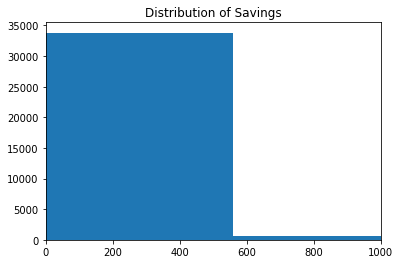

In [190]:
plt.hist(df.Savings, bins = 100)
plt.xlim(0,1000)
plt.title('Distribution of Savings')
plt.show()

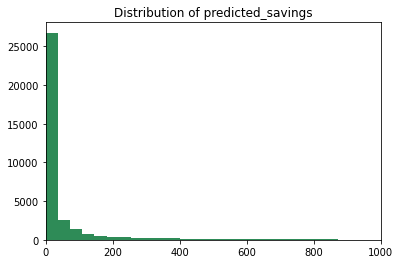

In [196]:
plt.hist(df.predicted_savings, bins = 100, color = 'seagreen')
plt.xlim(0,1000)
plt.title('Distribution of predicted_savings')
plt.show()

In [223]:
df.predicted_savings.sum()

2299665

In [5]:
dfsav = df.loc[df.Savings != 0]
print(dfsav.Savings.sum())

3046129


In [ ]:
len(dfsav)

In [ ]:
df.Spend.sum()

In [6]:
dfsub = df.loc[df.Savings == 0]

In [8]:
dfsub.predicted_savings.sum()

2299665

In [67]:
len(dfsub)

20031

In [224]:
dfsub.mean()

Unnamed: 0           10015.000
id                   10016.000
Spend                 1053.858
Segments                 3.158
Discount                 0.000
Savings                  0.000
predicted_savings      114.805
net_savings            114.805
Unnamed: 18                NaN
Unnamed: 19                NaN
Unnamed: 20                NaN
Unnamed: 21                NaN
dtype: float64

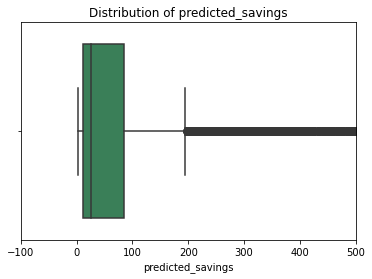

In [232]:
sns.boxplot(data = dfsub, x = dfsub.predicted_savings, color = 'seagreen')
plt.xlim(-100,500)
plt.title('Distribution of predicted_savings')
plt.show(b)

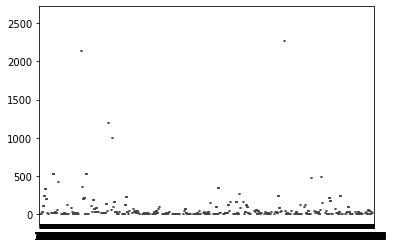

In [238]:
dfgrouby_Market = df.groupby(by = 'Market').mean()
sns.boxplot(data = dfgrouby_Market, x = dfgrouby_Market.index, y = dfgrouby_Market.predicted_savings )

In [69]:
dfsub.predicted_savings.describe()
print(dfsub.predicted_savings.sum())
print('20% negotiaion conversion: ', 0.2 * (dfsub.predicted_savings.sum()) )

2299665
20% negotiaion conversion:  459933.0


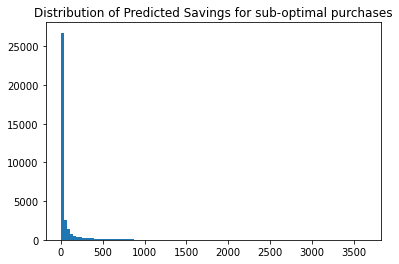

In [17]:
plt.hist(df.predicted_savings, bins = 100)
plt.title('Distribution of Predicted Savings for sub-optimal purchases')
plt.show()

In [18]:
df.predicted_savings.describe()

count    34851.000
mean        65.986
std        211.987
min          0.000
25%          0.000
50%          8.000
75%         32.000
max       3638.000
Name: predicted_savings, dtype: float64

In [21]:
df.groupby(["Market_Competition"]).sum().sort_values(by = ['predicted_savings'])[['Segments','Spend','Savings','predicted_savings']]

,Segments,Spend,Savings,predicted_savings
Market_Competition,,,,
Monopoly,20503,6320865,301025,337255
Highly Competitive,16062,7684952,498355,480059
Uncompetitive,27870,9716077,546032,516215
Competitive,52609,21594545,1700717,966136


In [22]:
df.groupby(["Market_Competition"]).mean().sort_values(by = ['predicted_savings'])[['Segments','Spend','Savings','predicted_savings']]

,Segments,Spend,Savings,predicted_savings
Market_Competition,,,,
Monopoly,3.030,934.210,44.491,49.846
Uncompetitive,3.272,1140.652,64.103,60.603
Competitive,3.542,1453.884,114.503,65.047
Highly Competitive,3.407,1630.240,105.718,101.837


In [24]:
df_groupby_market = df.groupby(["Market"]).sum().sort_values(by = ['predicted_savings'])[['Segments','Spend','Savings','predicted_savings']]

In [26]:
df_groupby_market.head()

,Segments,Spend,Savings,predicted_savings
Market,,,,
EWR-RDD,1,628,63,0
BUR-ROA,1,2099,315,0
BUR-SAN,1,163,8,0
GEG-SJC,3,624,30,0
BUR-SFO,14,1576,72,0


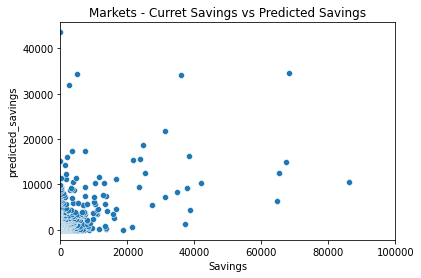

In [42]:
sns.scatterplot(x = df_groupby_market.Savings, y = df_groupby_market.predicted_savings)
plt.title("Markets - Curret Savings vs Predicted Savings")
plt.xlim(0,100000)
plt.show()

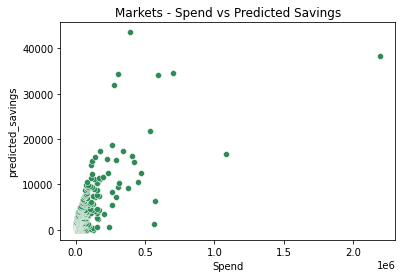

In [46]:
sns.scatterplot(x = df_groupby_market.Spend, y = df_groupby_market.predicted_savings, color = 'seagreen')
plt.title("Markets - Spend vs Predicted Savings")
plt.show()

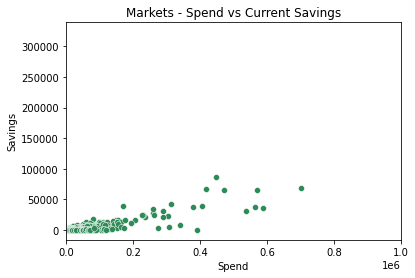

In [45]:
sns.scatterplot(x = df_groupby_market.Spend, y = df_groupby_market.Savings)
plt.title("Markets - Spend vs Current Savings")
plt.xlim(0,1000000)
plt.show()

# Random Selection Model Simulation and Analysis

In [166]:
%%time

dffull = pd.read_excel('master_file_markets_data_v2.0.xlsx')
dfcopy = dffull.copy()

#dropping columns that are not required, dropping markets with zero savings
#df = dffull.drop('id', axis = 1)
df = dffull.loc[dffull.Savings != 0] #training and testing set

# Definitions of training and testing data
# Validation data will only be suboptimal markets where, Savings = 0

df = df[['Segments','Spend','Market_type','Market_Competition','Savings']]


# Feature Encoding for machine learnign training

# Label Encoding
le = LabelEncoder()
df.Market_type = le.fit_transform(df.Market_type)
df.Market_Competition = le.fit_transform(df.Market_Competition)

'''
# One Hot Encoding

OneHotEncoder(
    categories='auto',  # Categories per feature
    drop=None, # Whether to drop one of the features
    sparse=True, # Will return sparse matrix if set True
    handle_unknown='error' # Whether to raise an error 
)        

ohe = OneHotEncoder() 


#OHE Encoding for column: POS
transformed = ohe.fit_transform(df[['POS']])
transformed = pd.DataFrame(data = transformed.toarray(), columns = ohe.get_feature_names())
df = df.drop('POS', axis = 1)
df = pd.concat([df, transformed], axis=1, join="inner")


#OHE Encoding for column: Region
transformed = ohe.fit_transform(df[['Region']])
transformed = pd.DataFrame(data = transformed.toarray(), columns = ohe.get_feature_names())
df = df.drop('Region', axis = 1)
df = pd.concat([df, transformed], axis=1, join="inner")

'''

# Extreme value removel
df = df.loc[df.Savings <= 5000]

# Standardisation and Normalisation for machine learnign training


# target 
#y = pd.DataFrame(data = dftest['y'])
y = df['Savings']

#features
x = df.drop('Savings', axis = 1)

# train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, shuffle = True)


# MODELLING

# Model Definitions List

#model_list = [RandomForestRegressor(n_estimators = 300, bootstrap = False, max_depth = 4, max_features = 4)]
model_list = [svm.SVR()]

#result storing lists; later to be used to generate dfresults dataframe
model_def = []
score_accuracy_list = []
score_explainedvariance_list = []
score_meanabsoluteerror_list = []

    
# model fitting and testing loop

for i in range(0,100) : 
    
    # storing model functions; later to be used in dfresults dataframe
    for model in model_list:
        text = str(model)
        #model_type = text.split(".")[-1].split("'")[0]
        model_type = text
        model_def.append(model_type)
    
    model = svm.SVR()

    #fitting
    fitted_model = model.fit(xtrain,ytrain)
    
    print('Model training completed completed for: ', model)
    
    ypred = fitted_model.predict(xtest)
    
    # scoring
    
    
    score_accuracy_list.append(fitted_model.score(xtest,ytest)) #calculate and append Accuracy
    score_explainedvariance_list.append(explained_variance_score(ytest,ypred)) #calculate and append R2 score
    score_meanabsoluteerror_list.append(mean_absolute_error(ytest,ypred)) #calculate and append R2 score



# Result storing - temporary
    
# result dataframe genertor, dfresults will be over written for new training runs
dfresults = pd.DataFrame(data = {'model':model_def, 'score_accuracy':score_accuracy_list, 
                                 'score_explained_variance':score_explainedvariance_list, 
                                 'score_mean_absolute_error':score_meanabsoluteerror_list})


# Result storing - permanent
 
#create a master file to store all results after training runs
#this below code needs to be seperated from training run cell
#re-executing the creation of dfresults_master will overwrite the dataframe

#load external csv file for result storage
dfresults_master = pd.read_csv('dfresults_master.csv')

#pre_processing dfresults_master to remove unnamed columns
Unname_columns_list = []
for column in dfresults_master.columns.to_list():
    if 'Unnamed' in column:
        Unname_columns_list.append(column)
dfresults_master = dfresults_master.drop(Unname_columns_list, axis = 1)

#append dataframe with results
dfresults_master = dfresults_master.append(dfresults) # stroing model testing scores into master dataframe
dfresults_master = dfresults_master[1:] #removing dummy observation 

#Removing any unknown columns that may have been appended
Unname_columns_list = []
for column in dfresults_master.columns.to_list():
    if 'Unnamed' in column:
        Unname_columns_list.append(column)

dfresults_master = dfresults_master.drop(Unname_columns_list, axis = 1)

#replace orgininally loaded file with new dataframe export
dfresults_master.to_csv('dfresults_master.csv')

dfresults.head()

#results need to be stored in dfresults_master for premanent record of all models trained

Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model training completed completed for:  SVR()
Model trainin

,model,score_accuracy,score_explained_variance,score_mean_absolute_error
0,SVR(),0.344,0.364,90.848
1,SVR(),0.344,0.364,90.848
2,SVR(),0.344,0.364,90.848
3,SVR(),0.344,0.364,90.848
4,SVR(),0.344,0.364,90.848


**Analysis of Random Forest Performance**

In [140]:
# Loading the results master
df = pd.read_csv('dfresults_master.csv')
df = df.drop('Unnamed: 0', axis = 1) #removing unnmaed column

# Adding another columns model_type into dfresults_master
df['model_type'] = pd.DataFrame(data = [0])

for i in df.index:

    model_name = str(df.model[i])
    model_name = model_name.split('(')
    model_type = model_name[0]
    df.model_type[i] = model_type

# Saving the model name of final model for XN project RFR(n=300)
final_model = str(df.model[1047])

#saving final model results in dfsim
dfsim = df.loc[df.model == final_model ]

dfsim.head()

<ipython-input-140-f7af2c131be4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.model_type[i] = model_type
/Users/siddhantwade/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,model,score_accuracy,score_explained_variance,score_mean_absolute_error,model_type
30,"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,\n n_estimators=300)",0.719,0.719,76.937,RandomForestRegressor
31,"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,\n n_estimators=300)",0.694,0.694,76.838,RandomForestRegressor
32,"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,\n n_estimators=300)",0.694,0.694,76.838,RandomForestRegressor
33,"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,\n n_estimators=300)",0.694,0.694,76.838,RandomForestRegressor
34,"RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,\n n_estimators=300)",0.694,0.694,76.838,RandomForestRegressor


In [87]:
dfsim.describe()

,score_accuracy,score_explained_variance,score_mean_absolute_error
count,1011.000,1011.000,1011.000
mean,0.703,0.703,76.941
std,0.001,0.001,0.010
min,0.694,0.694,76.838
25%,0.703,0.704,76.942
50%,0.703,0.704,76.942
75%,0.703,0.704,76.942
max,0.719,0.719,76.942


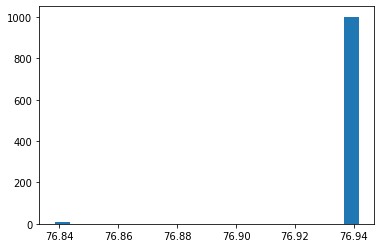

In [92]:
plt.hist(dfsim.score_mean_absolute_error, bins = 20)
plt.show()

# A very narrow interval at 95% confidence. The model is incredibly robust.

In [95]:
# 95% CI
dferror = dfsim['score_mean_absolute_error']
st.t.interval(alpha=0.95, df=len(dferror)-1, loc=np.mean(dferror), scale=st.sem(dferror)) 


<ipython-input-95-5ef8e7c973b1>:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(dferror)-1, loc=np.mean(dferror), scale=st.sem(dferror))


(76.94005627925893, 76.9413194483653)

**Analysis of Linear Regression performance**

In [170]:
# Loading the results master
df = pd.read_csv('dfresults_master.csv')
df = df.drop('Unnamed: 0', axis = 1) #removing unnmaed column

# Adding another columns model_type into dfresults_master
df['model_type'] = pd.DataFrame(data = [0])

for i in df.index:

    model_name = str(df.model[i])
    model_name = model_name.split('(')
    model_type = model_name[0]
    df.model_type[i] = model_type

# Saving the model name of final model for XN project RFR(n=300)
final_model = 'LinearRegression()'

#saving final model results in dfsim
dfsim = df.loc[df.model == final_model]

dfsim.head()

<ipython-input-170-46a6d5bd9135>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.model_type[i] = model_type
/Users/siddhantwade/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,model,score_accuracy,score_explained_variance,score_mean_absolute_error,model_type
24,LinearRegression(),0.656,0.656,83.889,LinearRegression
1141,LinearRegression(),0.656,0.656,89.901,LinearRegression
1142,LinearRegression(),0.656,0.656,89.901,LinearRegression
1143,LinearRegression(),0.656,0.656,89.901,LinearRegression
1144,LinearRegression(),0.656,0.656,89.901,LinearRegression


In [104]:
dfsim.describe()

,score_accuracy,score_explained_variance,score_mean_absolute_error
count,1.010e+02,1.010e+02,101.000
mean,6.556e-01,6.559e-01,89.842
std,1.276e-05,2.973e-05,0.598
min,6.555e-01,6.556e-01,83.889
25%,6.556e-01,6.559e-01,89.901
50%,6.556e-01,6.559e-01,89.901
75%,6.556e-01,6.559e-01,89.901
max,6.556e-01,6.559e-01,89.901


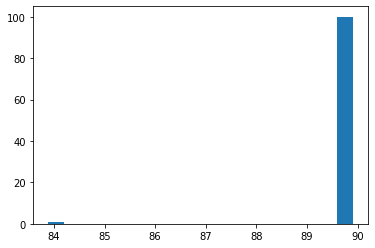

In [105]:
plt.hist(dfsim.score_mean_absolute_error, bins = 20)
plt.show()

In [107]:
# 95% CI
dferror = dfsim['score_mean_absolute_error']
st.t.interval(alpha=0.95, df=len(dferror)-1, loc=np.mean(dferror), scale=st.sem(dferror)) 

<ipython-input-107-5ef8e7c973b1>:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  st.t.interval(alpha=0.95, df=len(dferror)-1, loc=np.mean(dferror), scale=st.sem(dferror))


(89.72360985275175, 89.95979821775943)

**Comparative Simulation Performance**

In [160]:
dfgroupby_models = df.groupby(['model_type']).mean().sort_values(by = ['score_mean_absolute_error'], ascending = True)
dfgroupby_models

,score_accuracy,score_explained_variance,score_mean_absolute_error
model_type,,,
RandomForestRegressor,6.955e-01,6.956e-01,8.078e+01
LinearRegression,6.556e-01,6.559e-01,8.984e+01
DecisionTreeRegressor,5.263e-01,5.264e-01,9.442e+01
SGDRegressor,-4.551e+26,-3.714e+26,2.105e+15


In [161]:
dfgroupby_models = dfgroupby_models.drop('SGDRegressor')
dfgroupby_models

,score_accuracy,score_explained_variance,score_mean_absolute_error
model_type,,,
RandomForestRegressor,0.696,0.696,80.779
LinearRegression,0.656,0.656,89.842
DecisionTreeRegressor,0.526,0.526,94.418


<AxesSubplot: xlabel='model_type', ylabel='score_mean_absolute_error'>

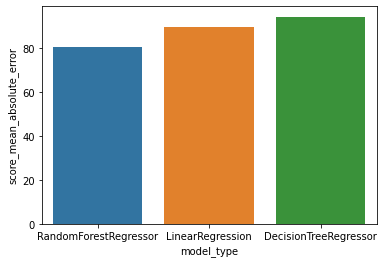

In [162]:
sns.barplot(data = dfgroupby_models, x = dfgroupby_models.index, y = dfgroupby_models.score_mean_absolute_error)

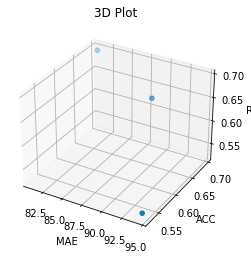

In [153]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axes
z = dfgroupby_models.score_explained_variance
x = dfgroupby_models.score_mean_absolute_error
y = dfgroupby_models.score_accuracy	
 
# plotting
ax.scatter(x, y, z,)
ax.set_title('3D Plot')
plt.xlabel('MAE')
plt.ylabel('ACC')
ax.set_zlabel('R2')
plt.show()

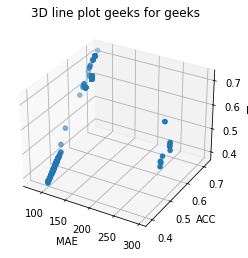

In [152]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axes
z = df.score_explained_variance
x = df.score_mean_absolute_error
y = df.score_accuracy
 
# plotting
ax.scatter(x, y, z,)
ax.set_title('3D Plot')
plt.xlabel('MAE')
plt.ylabel('ACC')
ax.set_zlabel('R2')
plt.show()

In [174]:
df.shape

(1642, 5)